In [1]:
# 激活函数 selu

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [5]:
# 批归一化为了防止梯度消失
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu'))
    model.add(keras.layers.BatchNormalization())
    """
    # 也可以把激活函数放在批归一化的后面
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(0.001),
              metrics=['accuracy'])

In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 100)               1

In [7]:
# batch_normalization  参数gamma beta moving_mean moving_variance
print(model.variables)

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
array([[-0.02914435, -0.0524586 ,  0.05218703, ...,  0.07199958,
        -0.05274285, -0.08173385],
       [-0.07217783,  0.07351799,  0.0730301 , ...,  0.03856498,
        -0.0461974 ,  0.00599191],
       [ 0.07946478,  0.07770917, -0.01397688, ...,  0.05266041,
         0.01062439,  0.04706281],
       ...,
       [-0.05237335,  0.01534723, -0.02968981, ...,  0.08176991,
         0.01796727,  0.03446387],
       [ 0.0486206 ,  0.03953424, -0.01283433, ...,  0.00543585,
         0.05322437,  0.05394799],
       [-0.05072877,  0.0223481 , -0.04220145, ..., -0.05163783,
        -0.03991   , -0.03058426]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0

In [8]:
logdir = './dnn_bn_selu_callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir, ),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks,workers=-1)

Epoch 1/100
1719/1719 [==============================] - 12s 5ms/step - loss: 0.8933 - accuracy: 0.6932 - val_loss: 0.5465 - val_accuracy: 0.8038
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6531 - accuracy: 0.7712 - val_loss: 0.4722 - val_accuracy: 0.8352
Epoch 3/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5882 - accuracy: 0.7917 - val_loss: 0.4393 - val_accuracy: 0.8462
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5516 - accuracy: 0.8062 - val_loss: 0.4196 - val_accuracy: 0.8514
Epoch 5/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5237 - accuracy: 0.8152 - val_loss: 0.4058 - val_accuracy: 0.8566
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5045 - accuracy: 0.8215 - val_loss: 0.3928 - val_accuracy: 0.8598
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4839 - accuracy: 0.8293 - val_loss: 0.3834 - val

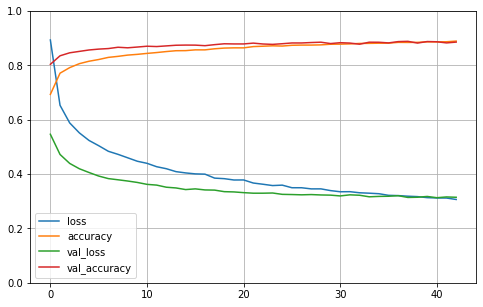

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


plot_learning_curves(history)

In [10]:
print(model.evaluate(x_test_scaled, y_test, verbose=0))



[0.34023892879486084, 0.8770999908447266]
